<a href="https://colab.research.google.com/github/OnurKerimoglu/bayesian_mmm/blob/main/bayesian_mmm_haensel_challenge.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Sources:
- [Blogpost #1](https://towardsdatascience.com/bayesian-marketing-mix-modeling-in-python-via-pymc3-7b2071f6001a) by Robert Kübler
- [Blogpost #2](https://towardsdatascience.com/modeling-marketing-mix-using-pymc3-ba18dd9e6e68) by Slava Kisilevich
-[Git repo #1](https://github.com/slavakx/bayesian_mmm) by Slava Kisilevich
-[Git repo #2](https://github.com/ikatsov/tensor-house/blob/master/promotions/mediamix-bayesian.ipynb) by Ilya Katsov

# User Settings

In [5]:
data_on_drive = True

# Install / Import Packages

In [1]:
!pip install pymc3

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 872.2/872.2 KB 14.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.8/1.8 MB 45.8 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for theano-pymc: filename=Theano_PyMC-1.1.2-py3-none-any.whl size=1529963 sha256=76896c4e593d8bb0765f80c4d17b974a00517d0cae15221f526f08229b4f2f79
  Stored in directory: /root/.cache/pip/wheels/0e/41/d2/82c7b771236f987def7fe2e51855cce22b270327f3fedec57c
Successfully built theano-pymc


In [21]:
import arviz as az
import matplotlib.pyplot as plt
import math
import numpy as np
import pandas as pd
import prophet
import pymc3 as pm3
import seaborn as sns
import theano
import theano.tensor as tt

from sklearn.preprocessing import MinMaxScaler, StandardScaler, PowerTransformer
from sklearn.metrics import mean_absolute_percentage_error, mean_squared_error


# Prepare Data

In [55]:
if data_on_drive == True:
  from google.colab import drive
  drive.mount('/content/drive')
  #!ls /content/drive/MyDrive/data/bayesian_mmm
  !cp '/content/drive/MyDrive/data/bayesian_mmm/MMM_test_data.csv' ./  

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [63]:
data_wdates = pd.read_csv(
  #'https://raw.githubusercontent.com/Garve/datasets/4576d323bf2b66c906d5130d686245ad205505cf/mmm.csv',
  'MMM_test_data.csv',
  parse_dates=['start_of_week']
)

## Extract Trend and Seasonality

In [62]:
from prophet import Prophet

In [93]:
prophet_data = data_wdates.rename(columns = {'revenue': 'y', 'start_of_week': 'ds'})

prophet = Prophet(yearly_seasonality=True, weekly_seasonality=False)

prophet.fit(prophet_data[["ds", "y"]])
prophet_predict = prophet.predict(prophet_data[["ds", "y"]])

INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkx4ebs2g/terh9zyg.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkx4ebs2g/p13ty1ub.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=40496', 'data', 'file=/tmp/tmpkx4ebs2g/terh9zyg.json', 'init=/tmp/tmpkx4ebs2g/p13ty1ub.json', 'output', 'file=/tmp/tmpkx4ebs2g/prophet_modelkptj_9re/prophet_model-20230126002731.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
00:27:32 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
00:27:32 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


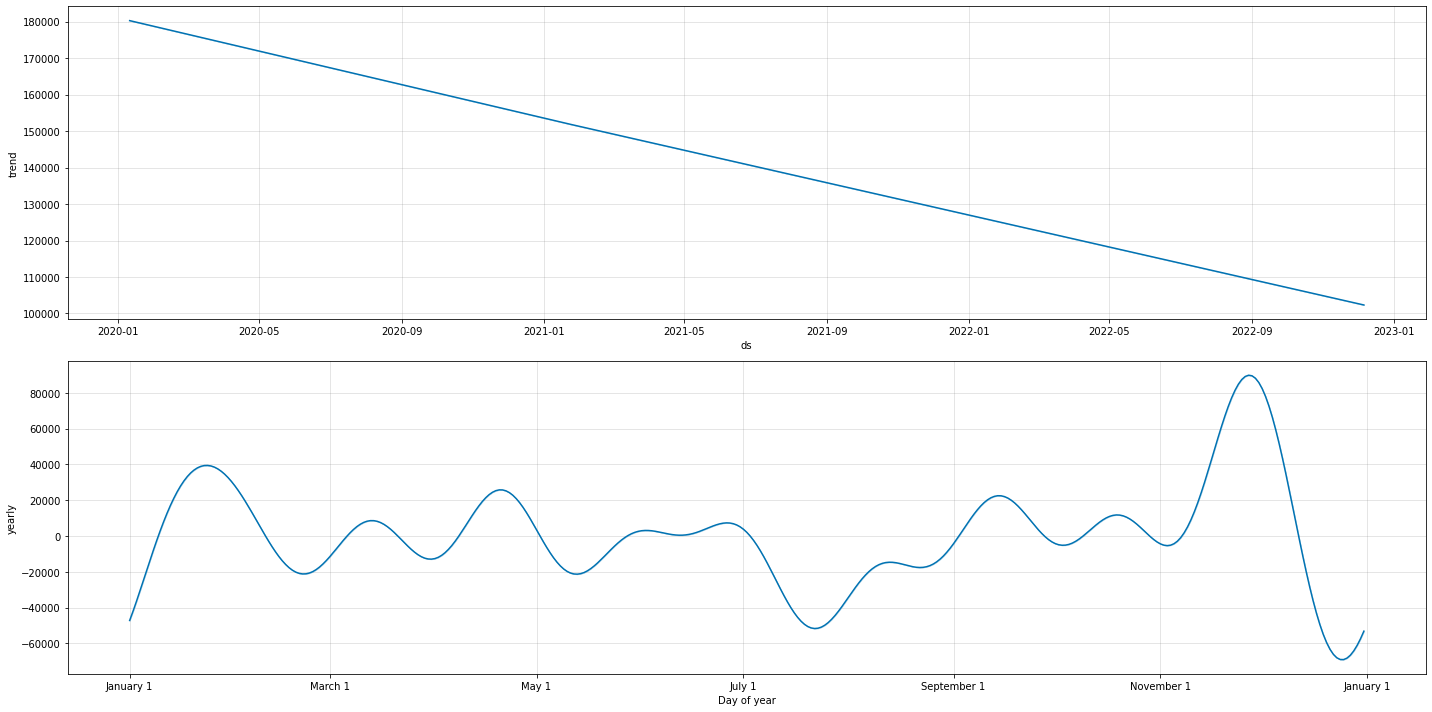

In [94]:
plot = prophet.plot_components(prophet_predict, figsize = (20, 10))

In [67]:
prophet_columns = [col for col in prophet_predict.columns if (col.endswith("upper") == False) & (col.endswith("lower") == False)]
events_numeric = prophet_predict[prophet_columns].filter(like = "events_").sum(axis = 1)

final_data = data_wdates.copy()
final_data["trend"] = prophet_predict["trend"]
final_data["season"] = prophet_predict["yearly"]

In [69]:
X = final_data.drop(columns=['revenue', 'start_of_week'])
y = final_data['revenue']

# Define the Model

In [18]:
#this is an infinite-length function but it slows down the code too much
def carryover_infinite(x, theta):
    x = tt.as_tensor_variable(x)
    #x = tt.vector("x")
    #theta = tt.scalar("theta")

    def carryover_infinite_recurrence(index, input_x, decay_x, theta):
        return tt.set_subtensor(decay_x[index], tt.sum(input_x + theta * decay_x[index - 1]))

    len_observed = x.shape[0]

    x_decayed = tt.zeros_like(x)
    x_decayed = tt.set_subtensor(x_decayed[0], x[0])

    output, _ = theano.scan(
        fn = carryover_infinite_recurrence, 
        sequences = [tt.arange(1, len_observed), x[1:len_observed]], 
        outputs_info = x_decayed,
        non_sequences = theta, 
        n_steps = len_observed - 1
    )
    
    return output[-1]

In [70]:
#Here is a simpler function with finite length as an explicit parameter
def carryover(x, strength, length=14):
    w = tt.as_tensor_variable(
        [tt.power(strength, i) for i in range(length)]
    )
    
    x_lags = tt.stack(
        [tt.concatenate([tt.zeros(i),x[:x.shape[0]-i]]) for i in range(length)]
    )
    
    return tt.dot(w, x_lags)

In [77]:
control_variables = ["trend", "season"]
delay_channels = ['spend_channel_1','spend_channel_2','spend_channel_3',
                  'spend_channel_4','spend_channel_5','spend_channel_6','spend_channel_7']
transform_variables = control_variables+delay_channels

y_transformed=y/10000 #rescale target variable

X_transformed = X.copy() #Min-max scale the features

numerical_encoder_dict = {}
for feature in transform_variables:
    scaler = MinMaxScaler()
    original = final_data[feature].values.reshape(-1, 1)
    transformed = scaler.fit_transform(original)
    X_transformed[feature] = transformed
    numerical_encoder_dict[feature] = scaler

with pm3.Model() as mmm1:
    channel_contributions = []
    
    for channel in delay_channels:
        print(f"Delay channels: Adding {channel}")
        #Force the channel coefficients to be normal:
        coef = pm3.HalfNormal(f'coef_{channel}', sigma = 2)
        car = pm3.Beta(f'car_{channel}', alpha=2, beta=2)
      
        channel_data = X_transformed[channel].values
        channel_contribution = pm3.Deterministic(
            f'contribution_{channel}',
            coef * carryover(
                    channel_data,
                    car),
            )
        
        channel_contributions.append(channel_contribution)
    
    control_contributions = []
    for control_var in control_variables:
        print(f"Control Variables: Adding {control_var}")
  
        x = X_transformed[control_var].values
  
        control_beta = pm3.Normal(f"control_{control_var}", sigma = 3)
        control_x = control_beta * x
        control_contributions.append(control_x)

    base = pm3.Normal("base", np.mean(y_transformed.values), sigma = 2)
    #base = pm3.Exponential('base', lam=0.01)
    noise = pm3.Exponential('noise', lam=0.1)

    sales = pm3.Normal(
        'sales',
        mu= base + sum(control_contributions) + sum(channel_contributions),
        sigma=noise,
        observed=y_transformed
    )

Delay channels: Adding spend_channel_1
Delay channels: Adding spend_channel_2
Delay channels: Adding spend_channel_3
Delay channels: Adding spend_channel_4
Delay channels: Adding spend_channel_5
Delay channels: Adding spend_channel_6
Delay channels: Adding spend_channel_7
Control Variables: Adding trend
Control Variables: Adding season
Control Variables: Adding week


## Do the prior distributions make sense?

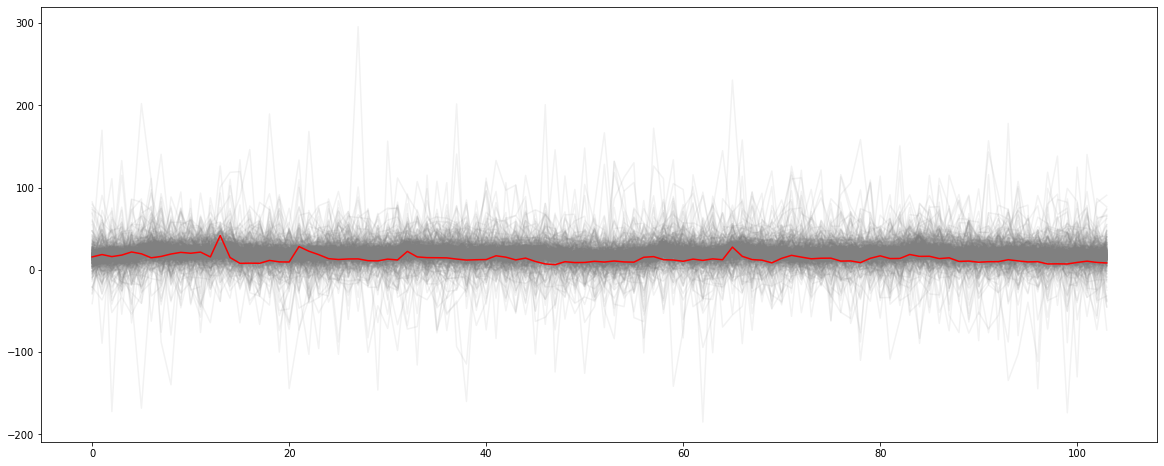

In [78]:
with mmm1:
    prior_pred = pm3.sample_prior_predictive()
prior_names = [prior_name for prior_name in list(prior_pred.keys()) if (prior_name.endswith("logodds__") == False) & (prior_name.endswith("_log__") == False)]
fig, ax = plt.subplots(figsize = (20, 8))
_ = ax.plot(prior_pred["sales"].T, color = "0.5", alpha = 0.1)
_ = ax.plot(y_transformed.values, color = "red")

carryover priors: 7
coef priors: 7
control coef priors: 4
sigma prior: 1


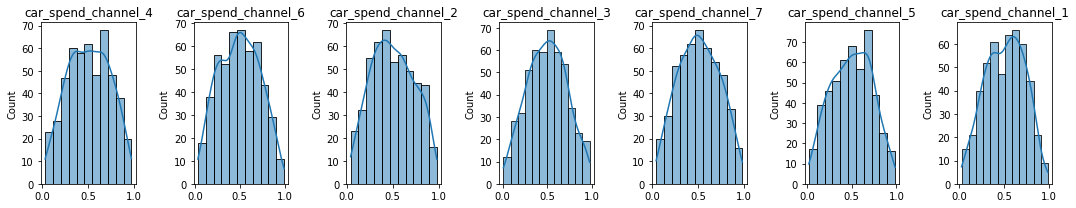

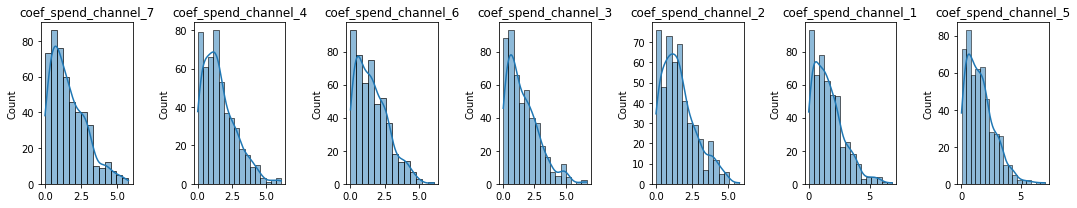

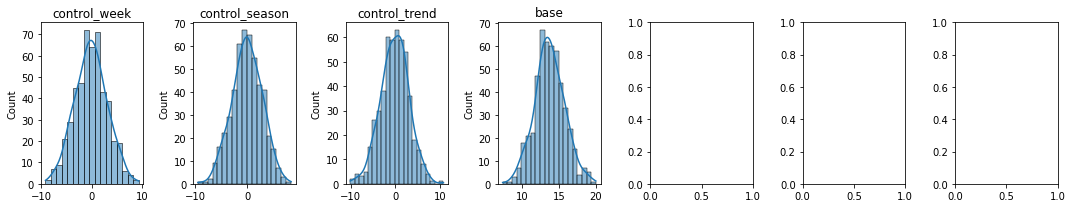

In [80]:
#plots priors using the random variables
def plot_priors(variables, prior_dictionary = None):
    if isinstance(variables[0], pm3.model.TransformedRV) == False and prior_dictionary is None:
        raise Exception("prior dictionary should be provided. It can be generated by sample_prior_predictive")
    cols = 7
    rows = int(math.ceil(len(variables)/cols))
    fig, ax = plt.subplots(rows, cols, figsize=(15, 3*rows))
    ax = np.reshape(ax, (-1, cols))
    for i in range(rows):
         for j in range(cols):
            vi = i*cols + j
            if vi < len(variables):
                var = variables[vi]
                if isinstance(var, pm3.model.TransformedRV):
                    sns.histplot(var.random(size=10000).flatten(), kde=True, ax=ax[i, j])
                    #p.set_axis_labels(var.name)
                    ax[i, j].set_title(var.name)
                else:
                    prior = prior_dictionary[var]
                    sns.histplot(prior, kde=True, ax = ax[i, j])
                    ax[i, j].set_title(var)
    plt.tight_layout()
    

adstock_priors = [p for p in prior_names if p.startswith("car")]
plot_priors(adstock_priors, prior_pred)
print(f"carryover priors: {len(adstock_priors)}")

# alpha_priors = [p for p in prior_names if p.startswith("sat")]
# plot_priors(alpha_priors, prior_pred)
# print(f"sat priors: {len(alpha_priors)}")

media_coef_priors = [p for p in prior_names if p.startswith("coef")]
plot_priors(media_coef_priors, prior_pred)
print(f"coef priors: {len(media_coef_priors)}")

control_coef_priors = [p for p in prior_names if p.startswith("control_")] + ["base"]
plot_priors(control_coef_priors, prior_pred)
print(f"control coef priors: {len(control_coef_priors)}")

#plot_priors(["sigma"], prior_pred)

print(f"sigma prior: 1")

## Fit the model

In [81]:
with mmm1:
  trace = pm3.sample(return_inferencedata=True, tune=3000, target_accept=0.95)
  trace_summary = az.summary(trace)

ERROR:pymc3:There were 25 divergences after tuning. Increase `target_accept` or reparameterize.
ERROR:pymc3:There were 25 divergences after tuning. Increase `target_accept` or reparameterize.
/usr/local/lib/python3.8/dist-packages/arviz/stats/diagnostics.py:586: RuntimeWarning: invalid value encountered in double_scalars
  (between_chain_variance / within_chain_variance + num_samples - 1) / (num_samples)


In [82]:
trace_summary

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
control_trend,2.291,1.868,-1.084,5.816,0.066,0.047,812.0,730.0,1.0
control_season,4.797,1.750,1.694,8.059,0.056,0.040,965.0,911.0,1.0
control_week,-1.613,1.736,-5.160,1.432,0.065,0.048,710.0,817.0,1.0
base,7.320,1.340,4.556,9.575,0.056,0.040,567.0,786.0,1.0
coef_spend_channel_1,0.908,0.760,0.002,2.312,0.021,0.015,821.0,579.0,1.0
...,...,...,...,...,...,...,...,...,...
contribution_spend_channel_7[100],0.459,0.340,0.000,1.068,0.010,0.008,1112.0,738.0,1.0
contribution_spend_channel_7[101],0.604,0.431,0.000,1.366,0.012,0.009,1048.0,674.0,1.0
contribution_spend_channel_7[102],0.620,0.444,0.000,1.404,0.013,0.009,1053.0,674.0,1.0
contribution_spend_channel_7[103],0.667,0.477,0.000,1.504,0.014,0.010,1046.0,651.0,1.0


In [47]:
# with mmm1:
#     ppc_all = pm3.sample_posterior_predictive(
#         trace, var_names=["sales"] + list(trace_summary.index), random_seed=42
#     )

In [48]:
# trace_summary = az.summary(trace)
# trace_summary = trace_summary.rename(columns={'mean': 'old_mean'})
# trace_summary["mean"] = np.inf


# for variable in list(trace_summary.index):
#     #mean_variable = ppc_all[variable].mean()
#     mean_variable = trace.posterior[variable].mean(axis = 0).mean().values
#     trace_summary.loc[trace_summary.index == variable, "mean"] = mean_variable
	
	
# y_true = y.values
# y_pred = ppc_all["outcome"].mean(axis = 0) * 100_000

# print(f"RMSE: {np.sqrt(np.mean((y_true - y_pred)**2))}")
# print(f"MAPE: {np.mean(np.abs((y_true - y_pred) / y_true))}")
# print(f"NRMSE: {nrmse(y_true, y_pred)}")

## Posterior distributions

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7fc0c46f51c0>,
      dtype=object)

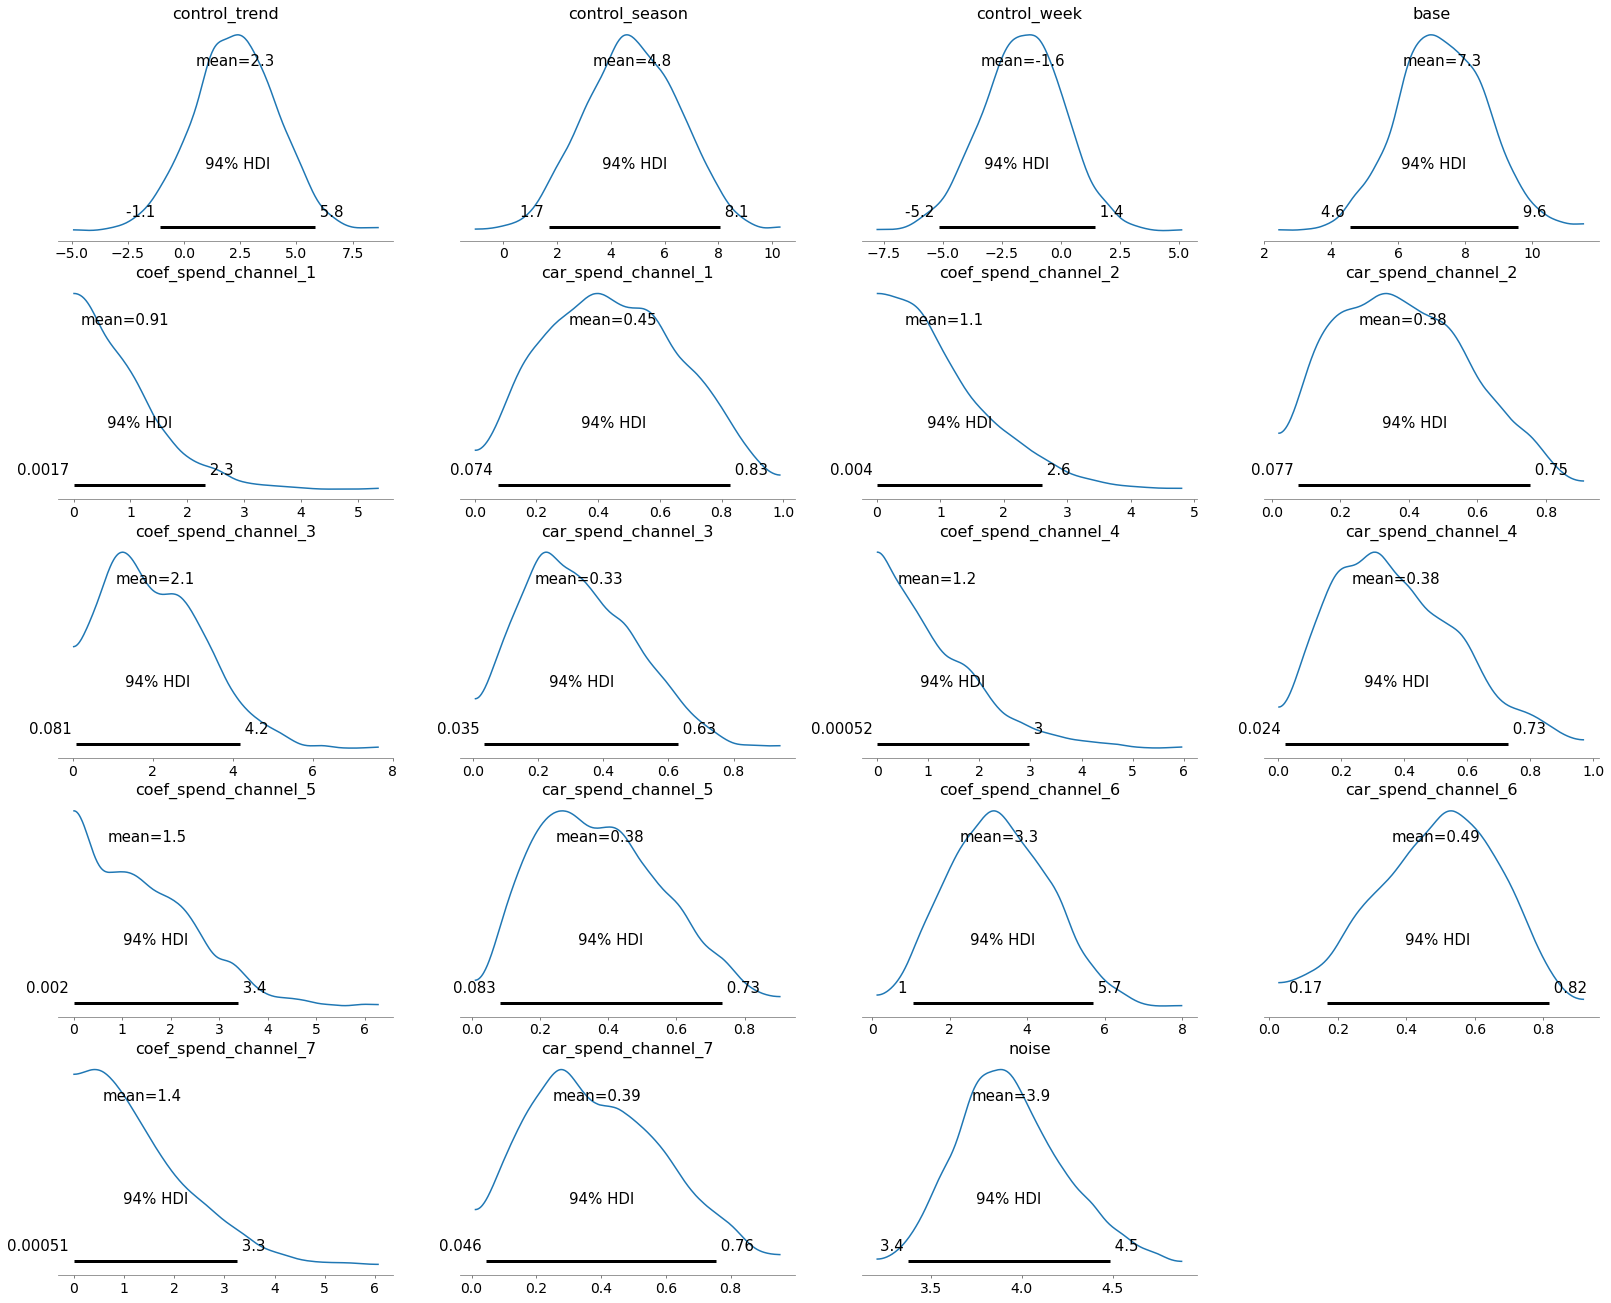

In [83]:
az.plot_posterior(
    trace,
    var_names=['~contribution'],
    filter_vars='like'
)

## Predictions vs Observations

In [84]:
import matplotlib.pyplot as plt
import numpy as np

with mmm1:
    posterior = pm3.sample_posterior_predictive(trace)

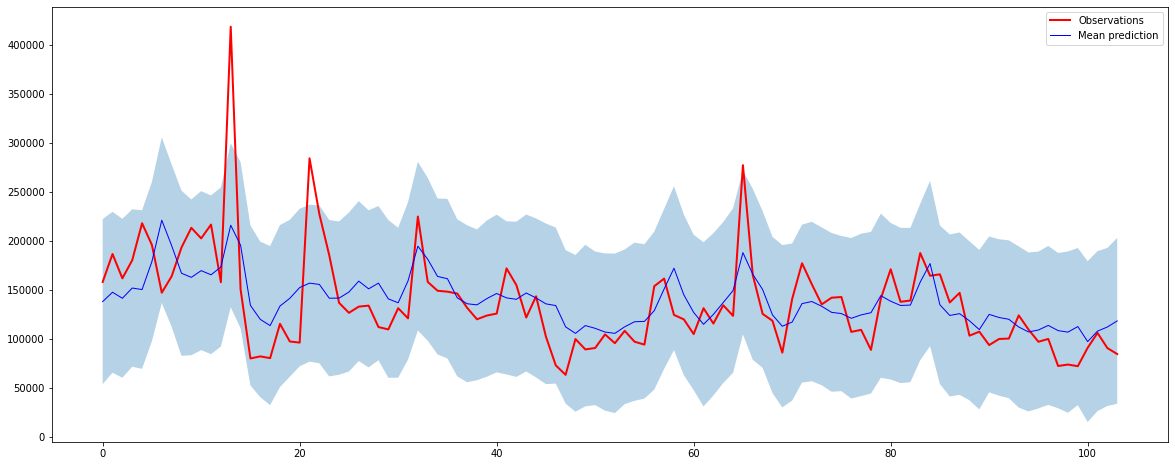

In [85]:
means = posterior['sales'].mean(0)*10000
stds = posterior['sales'].std(0)*10000

plt.figure(figsize=(20, 8))
plt.plot(y.values, linewidth=2, c='r', label='Observations')
plt.plot(means, linewidth=1, c='b', label='Mean prediction')
plt.fill_between(np.arange(len(y)), means - 2*stds, means + 2*stds, alpha=0.33)
plt.legend()

## Channel Contributions

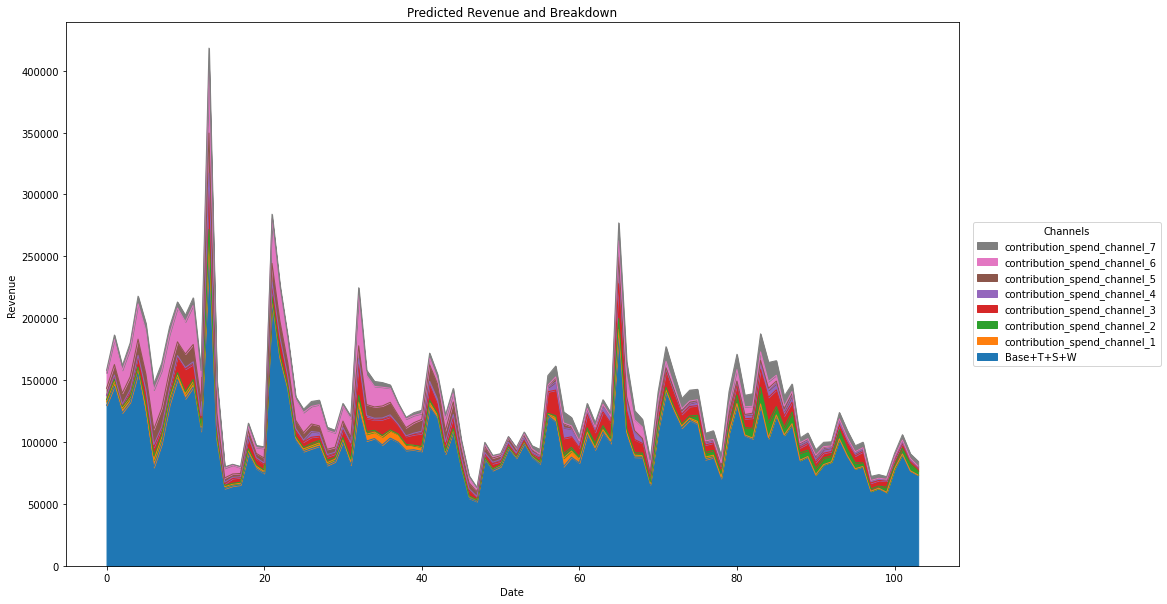

In [92]:
def compute_mean(trace, channel):
    return (trace
            .posterior[f'{channel}']
            .values
            .reshape(2000, 104)
            .mean(0)
           )

channels = ['contribution_spend_channel_1', 'contribution_spend_channel_2', 
            'contribution_spend_channel_3', 'contribution_spend_channel_4', 
            'contribution_spend_channel_5', 'contribution_spend_channel_6',
            'contribution_spend_channel_7']
unadj_contributions = pd.DataFrame(
    {'Base+T+S+W': trace.posterior['base'].values.mean()
                 +trace.posterior['control_trend'].values.mean()
                 +trace.posterior['control_season'].values.mean()},
    index=X.index
)

for channel in channels:
    unadj_contributions[channel] = compute_mean(trace, channel)

adj_contributions = (unadj_contributions
                     .div(unadj_contributions.sum(axis=1), axis=0)
                     .mul(y, axis=0)
                    )

ax = (adj_contributions
      .plot.area(
          figsize=(16, 10),
          linewidth=1,
          title='Predicted Revenue and Breakdown',
          ylabel='Revenue',
          xlabel='Date'
      )
     )
    
handles, labels = ax.get_legend_handles_labels()
ax.legend(
    handles[::-1], labels[::-1],
    title='Channels', loc="center left",
    bbox_to_anchor=(1.01, 0.5)
)